In [182]:
import os
import glob

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from utils.util import preprocessing, order_points
from dotenv import load_dotenv

"""
LOAD CONFIGURATIONS FROM .env FILE
"""
load_dotenv()

TRAIN_DATASET_CONNECT_PATH = f'{os.getcwd()}/{os.getenv("TRAIN_DATASET_CONNECT_PATH")}'
OUTPUT_PATH = f'{os.getcwd()}/{os.getenv("OUTPUT_PATH")}'

## Qwirkle Connect
*This Jupyter Notebook presents the work done by Vrinceanu Radu-Tudor (group 407 - Artificial Intelligence) for the Computer Vision subject.*

First step that I want to do is to import configs from the ```load_dotenv``` option that populates inside the Jupyter's Notebook runtime environment variables. After that we want to take each game image (load aprox. 21 images in memory 20 - which represents the whole game + 1 starting image). The starting image will represent the point for the "wrapping" algorithm that can center the board and remove translations or rotations. I also want to do for the first image (i.e. the starting one) the extraction of the board from the background by converting the image into an HSV color space and use some thresholds to obtain a mask that can be used in the retrieval of the board itself.

### First chapter of the adventure
**Extract just the boardgame from the starting image from the mask**

I know that each image of type ```g_00.jpg``` where $g = [1, 5]$ and g is a natural number. I define the function ```extract_boardgame_from_starting_image``` I will take the low and high threshold of hsv values to remove the surface on which the boardgame is placed. After that the Canny function will be used to fetch the edges and also determine the biggest polygon that can be build using the contour with the maximum area. This works because after applying the ```bitwise_and``` with the mask the remaining image will have a black background (i.e. dead pixels).

In [79]:
def extract_boardgame_from_image(image_name, path_to_dataset=TRAIN_DATASET_CONNECT_PATH):    
    first_image_path = os.path.join(path_to_dataset, f"{image_name}.jpg")
    first_image = cv.imread(first_image_path, cv.IMREAD_COLOR_BGR|cv.IMREAD_IGNORE_ORIENTATION)
    first_image = cv.resize(first_image, None, fx=0.8, fy=0.8)
    
    first_image_preprocessing = preprocessing(first_image) # get rid of textures by using median blur filters (texture can bring up noise in corner detection)
    
    hsv_threshold_low, hsv_threshold_high = (15, 0, 0), (255, 255, 255)
    hsv_first_image_preprocessing = cv.cvtColor(first_image_preprocessing, cv.COLOR_BGR2HSV)
    board_mask = cv.inRange(hsv_first_image_preprocessing, hsv_threshold_low, hsv_threshold_high)
    
    first_board_image = cv.bitwise_and(first_image, first_image, mask=board_mask)
    
    median_pixel_value = np.median(first_board_image)
    lower_threshold = int(max(0, (1.0 - 0.33) * median_pixel_value))
    upper_threshold = int(min(255, (1.0 + 0.33) * median_pixel_value))
    
    edges = cv.Canny(first_board_image, lower_threshold, upper_threshold)
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv.dilate(edges, kernel, iterations=1) # because of the noise on the edges these should be dilated to extract them!
    
    # plt.figure(figsize=[40, 10])
    # plt.axis('off'); plt.imshow(dilated_edges); plt.title('Canny Edges')
    
    contours, _ = cv.findContours(dilated_edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # cv.drawContours(first_board_image, contours, -1, (255, 0, 0), 1)
    # plt.figure(figsize=[40, 10])
    # plt.axis('off'); plt.imshow(first_board_image); plt.title('Contour boardgame')
    
    maximum_contour_area, best_contour_idx = 0.0, 0
    for (idx, contour) in enumerate(contours):
        area = cv.contourArea(contour)
        if area > maximum_contour_area:
            best_contour_idx = idx
            maximum_contour_area = area

    contour = contours[best_contour_idx]
    perimeter = cv.arcLength(contour, True)
    corners = cv.approxPolyDP(contour, 0.02 * perimeter, True)
    corners = order_points(corners)
        
    cv.drawContours(first_board_image, [corners], -1, (0, 255, 0), 20)
    # plt.figure(figsize=[40, 10])
    # plt.axis('off'); plt.imshow(first_board_image); plt.title('Contour boardgame')
    
    margin = 16
    height_with_gap, width_with_gap = 960 + margin*2, 960 + margin*2
    warp_to_with_gap = np.array([
        [margin, margin],
        [width_with_gap - margin, margin],
        [margin, height_with_gap - margin],
        [width_with_gap - margin, height_with_gap - margin]
    ]).astype(np.float32)
    perspective_matrix_with_gap = cv.getPerspectiveTransform(corners.astype(np.float32), warp_to_with_gap)

    height, width = 960, 960
    warp_to = np.array([[0, 0], [width, 0], [0, height], [width, height]]).astype(np.float32)
    perspective_matrix = cv.getPerspectiveTransform(corners.astype(np.float32), warp_to)
            
    return (cv.warpPerspective(first_image, perspective_matrix, dsize=(width, height)),
            cv.warpPerspective(first_image, perspective_matrix_with_gap, dsize=(width_with_gap, height_with_gap)))

Text(0.5, 1.0, 'Warpped with gap boardgame')

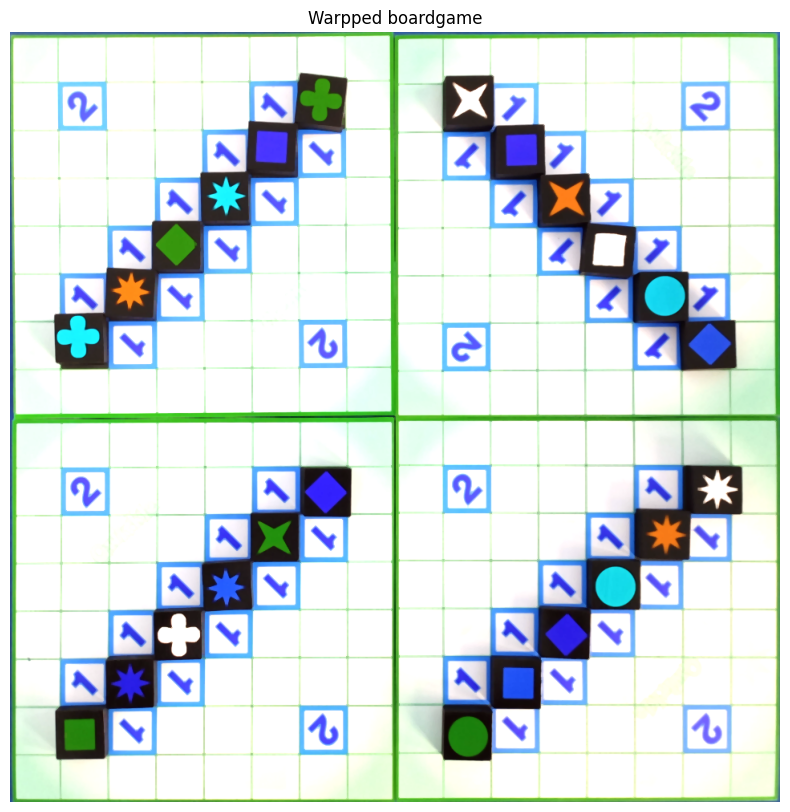

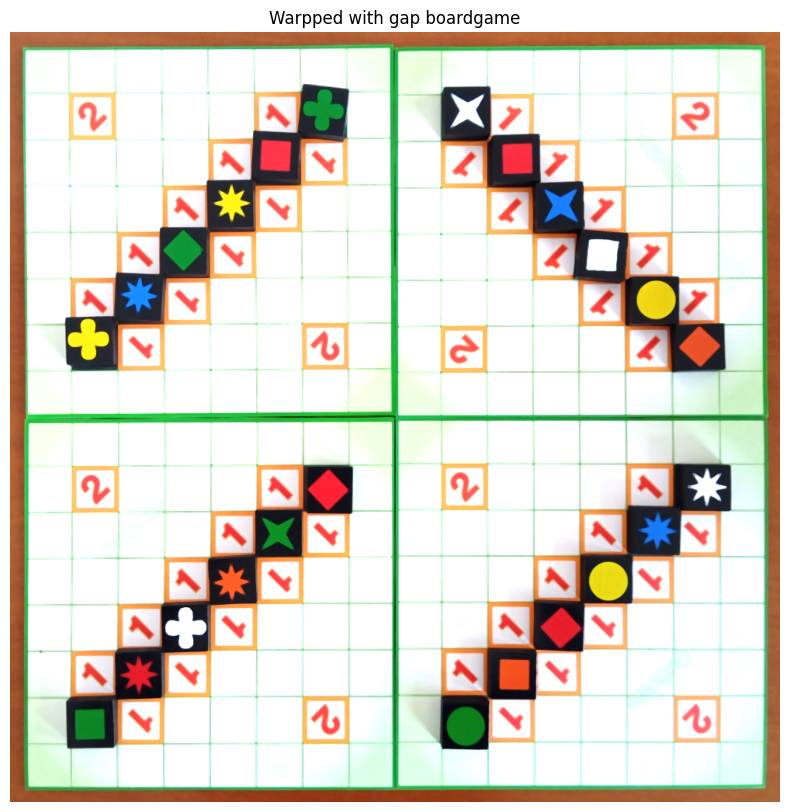

In [120]:
"""
TEST CODE
"""
warp, warp_with_gap = extract_boardgame_from_image("5_00")
warp = cv.medianBlur(warp, 3)
warp = cv.morphologyEx(warp, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
warp = cv.normalize(warp, None, alpha=0, beta=350, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)

warp_with_gap = cv.medianBlur(warp_with_gap, 3)
warp_with_gap = cv.morphologyEx(warp_with_gap, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
warp_with_gap = cv.normalize(warp_with_gap, None, alpha=0, beta=350, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)

plt.figure(figsize=[40, 10])
plt.axis('off'); plt.imshow(warp); plt.title('Warpped boardgame')

plt.figure(figsize=[40, 10])
plt.axis('off'); plt.imshow(cv.cvtColor(warp_with_gap, cv.COLOR_BGR2RGB)); plt.title('Warpped with gap boardgame')

### Second chapter of the adventure
**Extract the boardgame information (bonus points) and create a boardgame state**

Using template matching we can extract where the points sit on the table from the first image. It is guaranteed that the first image isn't that skewed and if it's the case consider the "middest" points on the table to get the orientation for each rectangle. Ensemble the game matrix based on $8x8$ patches that resembles each square of playable surface.

In [81]:
def extract_points_boardgame_from_image(image):
    game_points = np.zeros((16, 16))

    height, width = image.shape[:2]
    patch_height, patch_width = height // 16, width // 16

    list_of_points = np.array([(0, 0), (0, 1), (1, 0), (1, 1)])
    game_matrix = np.array([[
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 2, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]
    ], [
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 2, 0],
        [0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0],
        [0, 2, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]
    ]])
    list_of_roi_points = np.array([[(6, 6), (1, 6)], [(1, 9), (6, 9)], [(14, 6), (9, 6)], [(9, 9), (14, 9)]])
    template_paths = glob.glob('./datasets/templates/2_*.png')
    templates = list(map(
        lambda template_path: cv.imread(template_path, cv.IMREAD_COLOR_BGR|cv.IMREAD_IGNORE_ORIENTATION), template_paths
    ))

    for idx, roi_points_per_square in enumerate(list_of_roi_points):
        h1, w1 = roi_points_per_square[0]
        h2, w2 = roi_points_per_square[1]

        first_patch = image[h1*patch_height-5:(h1+1)*patch_height+5, w1*patch_width-5:(w1+1)*patch_width+5]
        second_patch = image[h2*patch_height-5:(h2+1)*patch_height+5, w2*patch_width-5:(w2+1)*patch_width+5]

        # plt.figure(figsize=[20, 10])
        # plt.subplot(121); plt.axis('off'); plt.imshow(cv.cvtColor(first_patch, cv.COLOR_BGR2RGB)); plt.title('First Patch')
        # plt.subplot(122); plt.axis('off'); plt.imshow(cv.cvtColor(second_patch, cv.COLOR_BGR2RGB)); plt.title('Second Patch')

        first_values, second_values = -np.inf, -np.inf
        for template in templates:
            first_result = cv.matchTemplate(first_patch, template, cv.TM_CCOEFF_NORMED)
            first_min_val, first_max_val, _, _ = cv.minMaxLoc(first_result)

            # if h1 == 9 and w1 == 9:
            #     print("First Value: ", first_min_val, first_max_val)

            if first_max_val > first_values:
                first_values = first_max_val

            second_result = cv.matchTemplate(second_patch, template, cv.TM_CCOEFF_NORMED)
            second_min_val, second_max_val, _, _ = cv.minMaxLoc(second_result)

            # if h1 == 9 and w1 == 9:
            #     print("Second Value: ", second_min_val, second_max_val)

            if second_max_val > second_values:
                second_values = second_max_val

        chosen_index = 0 if first_values > second_values else 1

        x, y = list_of_points[idx]
        game_points[x*8:(x+1)*8, y*8:(y+1)*8] = game_matrix[chosen_index]

    return game_points

In [82]:
"""
TEST CODE
"""
game_table_points = extract_points_boardgame_from_image(warp)
print(game_table_points)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Third chapter of the adventure
**Game phase, wrap the game image to the ```g_00.jpg```**

For this we will use a variant of SIFT descriptors which are called ORB descriptors (which represents a faster variant to SIFT descriptors and a newer algorithm). The resource that helped me understand those feature can be found here: https://www.youtube.com/watch?v=_o6fSMCmNnQ. Also, this means that in the middle of the game image T warps T+1 so ```g_00.jpg``` warps ```g_01.jpg``` and so on. I also recommend this article from medium: https://mikhail-kennerley.medium.com/a-comparison-of-sift-surf-and-orb-on-opencv-59119b9ec3d0.


In [7]:
def warp_image_to_starting_image_ORB(image_name, starting_game_image, path_to_dataset=TRAIN_DATASET_CONNECT_PATH):
    game_image = extract_boardgame_from_image(image_name, path_to_dataset=TRAIN_DATASET_CONNECT_PATH)
    
    gray_starting_game_image = cv.cvtColor(starting_game_image, cv.COLOR_BGR2GRAY)
    gray_game_image = cv.cvtColor(game_image, cv.COLOR_BGR2GRAY)

    MAX_NUM_OBSERVATIONS = 500
    orb = cv.ORB_create(MAX_NUM_OBSERVATIONS)
    keypoints_starting_game_image, description_starting_game_image = orb.detectAndCompute(gray_starting_game_image, None)
    keypoints_game_image, description_game_image = orb.detectAndCompute(gray_game_image, None)

    starting_game_display_image = cv.drawKeypoints(starting_game_image, keypoints_starting_game_image, outImage=np.array([]), color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    game_display_image = cv.drawKeypoints(game_image, keypoints_game_image, outImage=np.array([]), color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=[20, 10])
    plt.subplot(121); plt.axis('off'); plt.imshow(starting_game_display_image); plt.title('Starting image')
    plt.subplot(122); plt.axis('off'); plt.imshow(game_display_image); plt.title('Game image')

    """
    Compute the matches and extract them and discard p% of bad matches
    """
    matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(description_starting_game_image, description_game_image, None)
    matches = sorted(matches, key=lambda x: x.distance)

    matches = matches[:int(len(matches) * 0.15)]

    display_matches_image = cv.drawMatches(starting_game_image, keypoints_starting_game_image, game_image, keypoints_game_image, matches, None)
    plt.figure(figsize=[40, 10])
    plt.axis('off'); plt.imshow(display_matches_image); plt.title('Matches')

    """
    Compute homography matrix
    """
    points_starting_game_image = np.zeros((len(matches), 2), dtype=np.float32)
    points_game_image = np.zeros((len(matches), 2), dtype=np.float32)

    for (i, match) in enumerate(matches):
        points_starting_game_image[i, :] = keypoints_starting_game_image[match.queryIdx].pt
        points_game_image[i, :] = keypoints_game_image[match.trainIdx].pt

    h, _ = cv.findHomography(points_game_image, points_starting_game_image, cv.RANSAC)

    height, width, _ = starting_game_image.shape
    warped_image = cv.warpPerspective(game_image, h, (width, height))

    plt.figure(figsize=[20, 10])
    plt.subplot(121); plt.axis('off'); plt.imshow(starting_game_image); plt.title('Starting image')
    plt.subplot(122); plt.axis('off'); plt.imshow(warped_image); plt.title('Game image - Warped')

    return warped_image
    

In [122]:
import math


def extract_rotation_angle_from_homography(H):
    # Normalize
    H = H / H[2, 2]

    # Extract the rotation matrix (first 2 columns of H)
    r1 = H[:, 0]
    r2 = H[:, 1]

    # Orthonormalize using Gram-Schmidt (for robustness)
    r1 = r1 / np.linalg.norm(r1)
    r2 = r2 - np.dot(r1, r2) * r1
    r2 = r2 / np.linalg.norm(r2)

    # Compute rotation angle around Z (assuming flat plane)
    angle_rad = math.atan2(r1[1], r1[0])  # sin, cos
    angle_deg = math.degrees(angle_rad)
    
    return angle_deg


def warp_image_to_starting_image_SIFT(game_image, starting_game_image, path_to_dataset=TRAIN_DATASET_CONNECT_PATH):
    if type(game_image) == str:
        game_image, _ = extract_boardgame_from_image(game_image, path_to_dataset=TRAIN_DATASET_CONNECT_PATH)
        game_image = cv.medianBlur(game_image, 3)
        game_image = cv.morphologyEx(game_image, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
        game_image = cv.normalize(game_image, None, alpha=0, beta=350, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)

    sift = cv.SIFT_create()
    keypoints_starting_game_image, description_starting_game_image = sift.detectAndCompute(starting_game_image, None)
    keypoints_game_image, description_game_image = sift.detectAndCompute(game_image, None)

    # starting_game_display_image = cv.drawKeypoints(starting_game_image, keypoints_starting_game_image, outImage=np.array([]), color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # game_display_image = cv.drawKeypoints(game_image, keypoints_game_image, outImage=np.array([]), color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # 
    # plt.figure(figsize=[20, 10])
    # plt.subplot(121); plt.axis('off'); plt.imshow(cv.cvtColor(starting_game_display_image, cv.COLOR_BGR2RGB)); plt.title('Starting image')
    # plt.subplot(122); plt.axis('off'); plt.imshow(cv.cvtColor(game_display_image, cv.COLOR_BGR2RGB)); plt.title('Game image')

    """
    Compute the matches and extract them and discard p% of bad matches
    """
    matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
    matches = matcher.match(description_starting_game_image, description_game_image, None)
    matches = sorted(matches, key=lambda x: x.distance)

    # display_matches_image = cv.drawMatches(starting_game_image, keypoints_starting_game_image, game_image, keypoints_game_image, matches, None)
    # plt.figure(figsize=[40, 10])
    # plt.axis('off'); plt.imshow(cv.cvtColor(display_matches_image, cv.COLOR_BGR2RGB)); plt.title('Matches')

    """
    Compute homography matrix
    """
    points_starting_game_image = np.zeros((len(matches), 2), dtype=np.float32)
    points_game_image = np.zeros((len(matches), 2), dtype=np.float32)

    for (i, match) in enumerate(matches):
        points_starting_game_image[i, :] = keypoints_starting_game_image[match.queryIdx].pt
        points_game_image[i, :] = keypoints_game_image[match.trainIdx].pt

    h, _ = cv.findHomography(points_game_image, points_starting_game_image, cv.RANSAC)
    degrees_rotation = extract_rotation_angle_from_homography(h)
    print(degrees_rotation)
    height, width, _ = starting_game_image.shape
    warped_image = cv.warpPerspective(game_image, h, (width, height))

    # plt.figure(figsize=[20, 10])
    # plt.subplot(121); plt.axis('off'); plt.imshow(cv.cvtColor(starting_game_image, cv.COLOR_BGR2RGB)); plt.title('Starting image')
    # plt.subplot(122); plt.axis('off'); plt.imshow(cv.cvtColor(warped_image, cv.COLOR_BGR2RGB)); plt.title('Game image - Warped')

    return warped_image, degrees_rotation
    

In [124]:
"""
TEST CODE
"""
image, _ = warp_image_to_starting_image_SIFT("5_01", warp)
image, _  = warp_image_to_starting_image_SIFT("5_02", image)
image, _  = warp_image_to_starting_image_SIFT("5_03", image)
image, _  = warp_image_to_starting_image_SIFT("5_04", image)
image, _  = warp_image_to_starting_image_SIFT("5_05", image)
image, _  = warp_image_to_starting_image_SIFT("5_06", image)
image, _  = warp_image_to_starting_image_SIFT("5_07", image)
image, _  = warp_image_to_starting_image_SIFT("5_08", image)
image, _  = warp_image_to_starting_image_SIFT("5_09", image)

178.73080226187523
178.80873826875495
178.39118212480818
178.46010431111998
-0.7789199410373767
-0.6514182026555058
-1.9008980576198045
-1.6267311827423057
-1.536775131394174


## Fourth Chapter of the Adventure
**How to extract pieces from the table?**

Maybe template matching or SIFT descriptors where matches land near a position consider the maximum matches points to represent the position for that

In [180]:
import re
from collections import defaultdict, deque

templates_config = {
    'red': glob.glob(os.path.join('./datasets/templates', 'red_*.png')),
    'orange': glob.glob(os.path.join('./datasets/templates', 'orange_*.png')),
    'blue': glob.glob(os.path.join('./datasets/templates', 'blue_*.png')),
    'yellow': glob.glob(os.path.join('./datasets/templates', 'yellow_*.png')),
    'green': glob.glob(os.path.join('./datasets/templates', 'green*.png')),
    'white': glob.glob(os.path.join('./datasets/templates', 'white_*.png')),
}

def extract_code_cell(x, y):
    code = ""
    code += str(x + 1)
    code += chr(ord('A') + y)
    return code

def shape_name_to_code(color_name, pattern_name):
    code = ""
    match_shape_name = re.search(r'.*\_(.*)\.png', pattern_name)
    if match_shape_name is None:
        raise Exception("Cannot find shape name in the name of the template.")
    
    shape_name = match_shape_name.group(1)
    if shape_name == "circle":
        code += "1"
    elif shape_name == "clover":
        code += "2"
    elif shape_name == "diamond":
        code += "3"
    elif shape_name == "square":
        code += "4"
    elif shape_name == "star":
        code += "5"
    elif shape_name == "8-star":
        code += "6"
    else:
        code += "?"
        
    if color_name == "red":
        code += "R"
    elif color_name == "orange":
        code += "O"
    elif color_name == "blue":
        code += "B"
    elif color_name == "yellow":
        code += "Y"
    elif color_name == "green":
        code += "G"
    elif color_name == "white":
        code += "W"
    else:
        code += "?"
    return code
    

def extract_pieces_from_table(warp_with_gap):
    image_copy = warp_with_gap.copy()
    game_matrix = [["?"] * 16 for _ in range(16)]
    for i, patch_i in enumerate(range(16, 976, 60)):
        for j, patch_j in enumerate(range(16, 976, 60)):
            pattern = image_copy[patch_i-16:patch_i+60+16, patch_j-16:patch_j+60+16]
            
            color_detections = defaultdict(list)
            for color_name, template_paths in templates_config.items():
                for template_path in template_paths:
                    current_template = cv.imread(template_path, cv.IMREAD_COLOR_BGR|cv.IMREAD_IGNORE_ORIENTATION)
                    h, w = current_template.shape[:2]
                    
                    res = cv.matchTemplate(pattern, current_template, cv.TM_CCOEFF_NORMED)
                    maximum_result_coefficient = np.max(res)
                    
                    color_detections[color_name].append((maximum_result_coefficient, template_path))
                color_detections[color_name] = max(color_detections[color_name], key=lambda element: element[0])
            
            color_key = max(color_detections, key=lambda element: color_detections[element][0])
            if color_detections[color_key][0] > 0.8:
                code = shape_name_to_code(color_key, color_detections[color_key][1])
                game_matrix[i][j] = code
    return game_matrix


55 55
(92, 92, 3)
[0.03279221 0.05257447 0.07411294 0.09598704 0.11796872 0.1399509
 0.16209328 0.18500759 0.20937718 0.23688242 0.26782274 0.30224225
 0.33840433 0.3769712  0.41724414 0.46025267 0.5027135  0.543255
 0.58045053 0.6130646  0.6398701  0.66184855 0.6798336  0.6938289
 0.7036545  0.7093883  0.71130615 0.7097802  0.7047844  0.6958906
 0.68290234 0.66587687 0.6445101  0.6187356  0.58857906 0.55445856
 0.51693946 0.4767218 ]
(938, 938)
(array([558, 558, 558, 559, 559, 559, 560, 560, 560, 739, 739, 740, 740,
       740, 740, 741, 741, 741, 741, 742, 742]), array([138, 139, 140, 138, 139, 140, 138, 139, 140, 256, 257, 255, 256,
       257, 258, 255, 256, 257, 258, 256, 257])) [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(array([558, 558, 558, 559, 559, 559, 560, 

Text(0.5, 1.0, 'Lets seee')

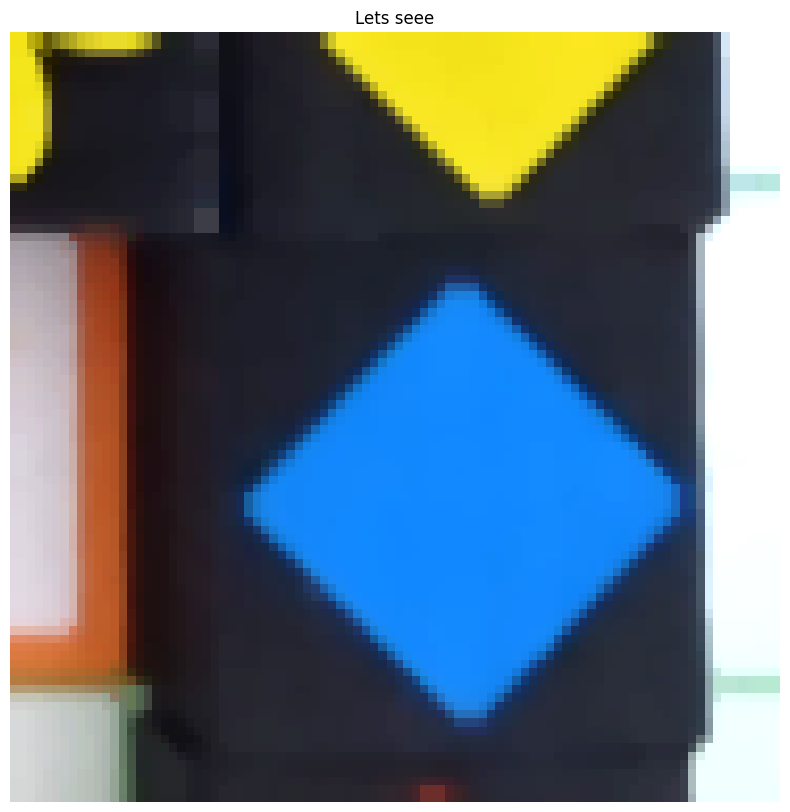

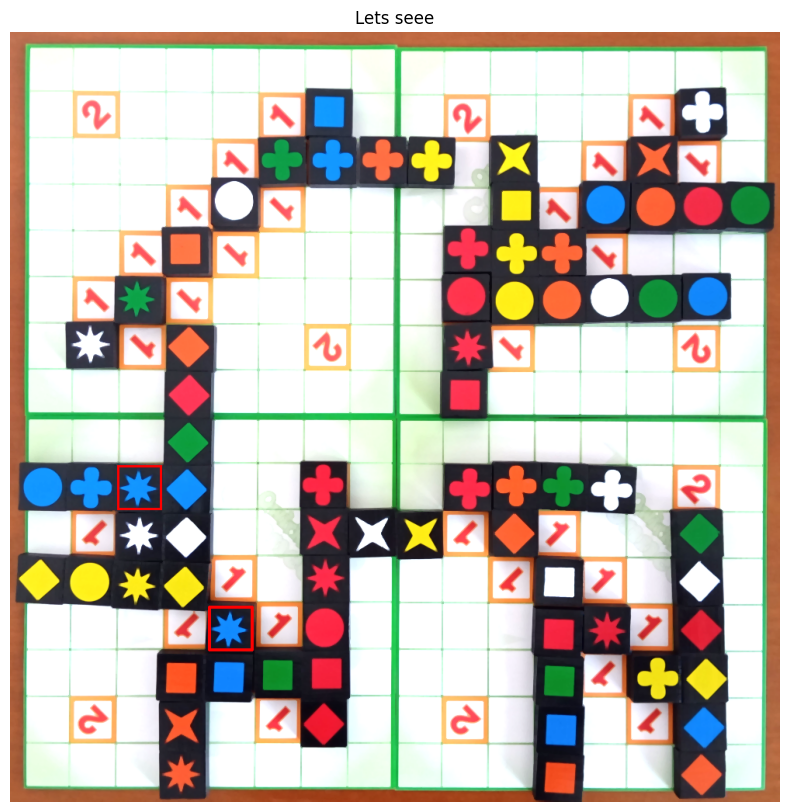

In [101]:
"""
TEST CODE
"""
template = cv.imread("./datasets/templates/blue_8-star.png", cv.IMREAD_COLOR_BGR|cv.IMREAD_IGNORE_ORIENTATION)
# only resize if needed TODO
h, w = template.shape[:2]
print(h, w)
image_copy = warp_with_gap.copy()
other_image_copy = warp_with_gap.copy()
# pattern1 = image_copy[720-10:780+10, 840-10:900+10]
pattern1 = image_copy[856-16:916+16, 856-16:916+16]
# pattern1 = image_copy[0:60+10, 300-10:360+10]
# pattern1 = image_copy[600-5:660-5, 120+5:180+5]

pattern1 = cv.morphologyEx(pattern1, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
print(pattern1.shape)
image_copy = cv.morphologyEx(image_copy, cv.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)
res = cv.matchTemplate(other_image_copy, template, cv.TM_CCOEFF_NORMED)
res1 = cv.matchTemplate(pattern1, template, cv.TM_CCOEFF_NORMED)
print(np.max(res1, axis=1))
threshold = 0.85
loc1 = np.where( res1 >= threshold)
for pt in zip(*loc1[::-1]):
    cv.rectangle(pattern1, pt, (pt[0] + h, pt[1] + w), (0,0,255), 1)
plt.figure(figsize=[40, 10])
plt.axis('off'); plt.imshow(cv.cvtColor(pattern1, cv.COLOR_BGR2RGB)); plt.title('Lets seee')
print(res.shape)
threshold = 0.9
loc = np.where( res >= threshold)
print(loc, res >= threshold)
print(loc)
for pt in zip(*loc[::-1]):
    cv.rectangle(other_image_copy, pt, (pt[0] + h, pt[1] + w), (0,0,255), 1)
# 0 60 120 180 240 300 360 420 480 540 600 660 720 780 840 900 960
plt.figure(figsize=[40, 10])
plt.axis('off'); plt.imshow(cv.cvtColor(other_image_copy, cv.COLOR_BGR2RGB)); plt.title('Lets seee')

Text(0.5, 1.0, 'Lets seee')

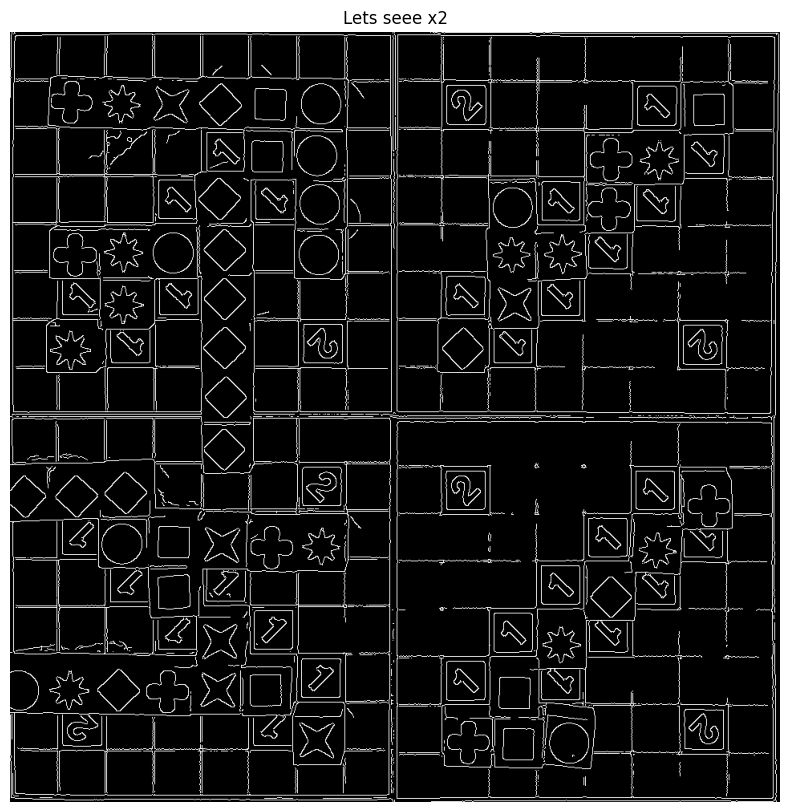

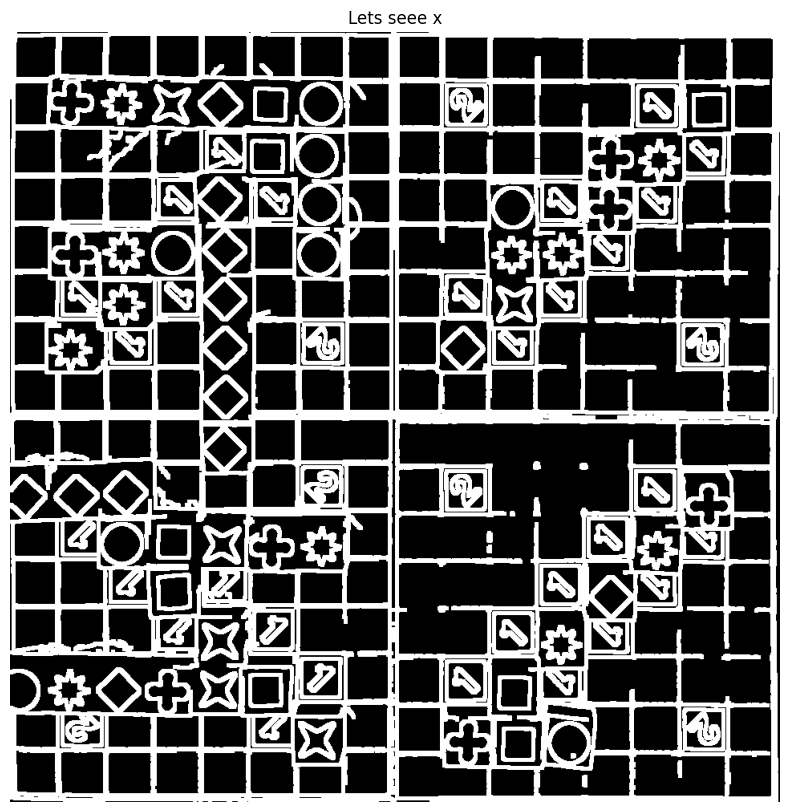

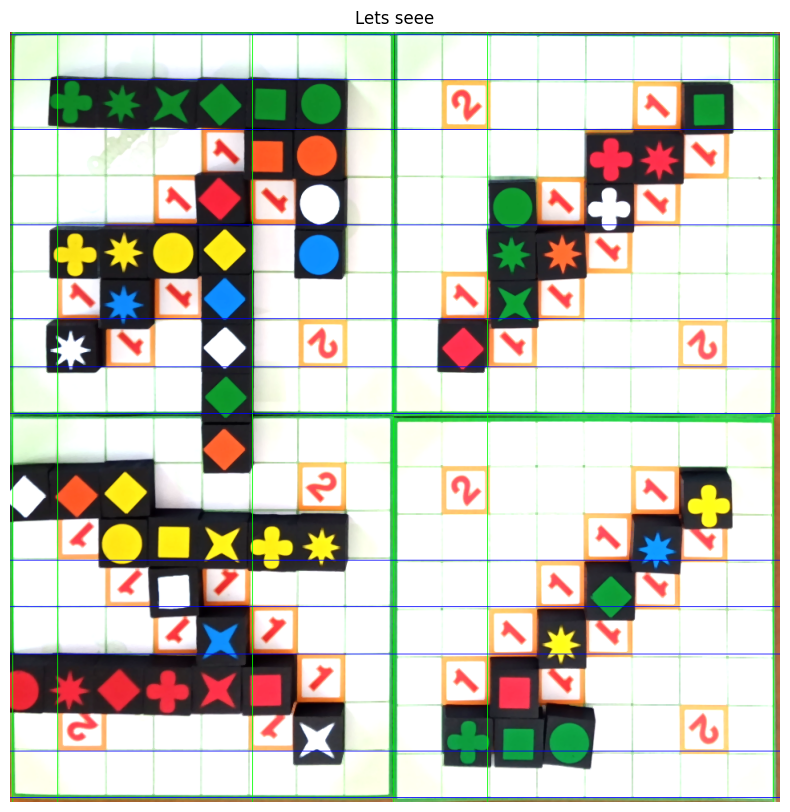

In [68]:
"""
TEST CODE
"""
def generate_horizontal_vertical_lines(img):
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray_img, 40, 70, apertureSize=3)
    plt.figure(figsize=[40, 10])
    plt.axis('off'); plt.imshow(cv.cvtColor(edges, cv.COLOR_BGR2RGB)); plt.title('Lets seee x2')
    
    kernel_edges = np.ones((3, 3), np.uint8)
    dilated_edges = cv.dilate(edges, kernel_edges, iterations=2)
    plt.figure(figsize=[40, 10])
    plt.axis('off'); plt.imshow(cv.cvtColor(dilated_edges, cv.COLOR_BGR2RGB)); plt.title('Lets seee x')
    lines = cv.HoughLinesP(dilated_edges,
                            rho=1,
                            theta=np.pi/180,
                            threshold=200,
                            minLineLength=warp.shape[1]//2,
                            maxLineGap=20)
    
    horiz, vert = [], []
    for x1,y1,x2,y2 in lines[:,0]:
        if abs(y2-y1) < 10:
            horiz.append((x1,y1,x2,y2))
        elif abs(x2-x1) < 10:
            vert.append((x1,y1,x2,y2))
    return horiz, vert

def cluster_line_positions(lines, orientation='vertical', tol=20):
    coords = []
    for x1, y1, x2, y2 in lines:
        coords.append(((x1+x2)//2) if orientation=='vertical' else ((y1+y2)//2))
    coords.sort()
    clusters = []
    for c in coords:
        if not clusters or abs(c - clusters[-1][0]) > tol:
            clusters.append([c])
        else:
            clusters[-1].append(c)
    centers = [int(np.mean(cluster)) for cluster in clusters]
    return sorted(centers)

horiz, vert = generate_horizontal_vertical_lines(warp)
xs = cluster_line_positions(vert, 'vertical', tol=20)
ys = cluster_line_positions(horiz, 'horizontal', tol=20)

"""
DEBUG CHECK LINES:
"""
def draw_grid_lines(board, xs, ys):
    img = board.copy()
    for x in xs:
        cv.line(img, (x, 0), (x, img.shape[0]), (0, 255, 0), 1)
    for y in ys:
        cv.line(img, (0, y), (img.shape[1], y), (255, 0, 0), 1)
    return img

img = draw_grid_lines(warp, xs, ys)
plt.figure(figsize=[40, 10])
plt.axis('off'); plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)); plt.title('Lets seee')

In [197]:
from collections import deque

def compute_score(new_positions, game_state, game_table_points):
    """
    Take into account QWIRKLE (6 in a row of same color?)
    """
    points = 0
    if len(new_positions) >= 2:
        x1, y1 = new_positions[0]
        x2, y2 = new_positions[1]
        
        # Same line (row) different columns
        if x1 == x2:
            directions = [(0, -1), (0, 1)]
            different_directions = [(-1, 0), (1, 0)]
        else:
            directions = [(-1, 0), (1, 0)]
            different_directions = [(0, -1), (0, 1)]
        
        visited = np.zeros((16, 16))
        queue_checking = deque(new_positions)
        line_length = 0
        while queue_checking:
            current_point = queue_checking.popleft()
            x, y = current_point
            
            if visited[x, y]:
                continue
            
            line_length += 1
            if game_table_points[x][y]:
                points += game_table_points[x][y]
                game_table_points[x][y] = 0
                
            for direction in directions:
                new_x = x + direction[0]
                new_y = y + direction[1]
                if not (0 <= new_x < 16 and 0 <= new_y < 16):
                    continue
                
                if not visited[new_x, new_y] and game_state[new_x][new_y] != "?":
                    queue_checking.append((new_x, new_y))
            visited[x, y] = 1
        print(points, line_length)
        points += 0 if line_length <= 1 else line_length
        if line_length == 6:
            points += 6
        
        print(points, line_length)
        for new_position in new_positions:
            visited = np.zeros((16, 16))
            queue_checking = deque([new_position])
            line_length = 0
            while queue_checking:
                current_point = queue_checking.popleft()
                x, y = current_point
                
                if visited[x, y]:
                    continue
                
                line_length += 1
                if game_table_points[x][y]:
                    points += game_table_points[x][y]
                    game_table_points[x][y] = 0
                    
                for direction in different_directions:
                    new_x = x + direction[0]
                    new_y = y + direction[1]
                    if not (0 <= new_x < 16 and 0 <= new_y < 16):
                        continue
                    
                    if not visited[new_x, new_y] and game_state[new_x][new_y] != "?":
                        queue_checking.append((new_x, new_y))
                visited[x, y] = 1
                
            points += 0 if line_length <= 1 else line_length
            if line_length == 6:
                points += 6
    else:
        directions = [(0, -1), (0, 1)]
        different_directions = [(-1, 0), (1, 0)]
        
        visited = np.zeros((16, 16))
        queue_checking = deque(new_positions)
        line_length = 0
        while queue_checking:
            current_point = queue_checking.popleft()
            x, y = current_point
            
            if visited[x, y]:
                continue
            
            line_length += 1
            if game_table_points[x][y]:
                points += game_table_points[x][y]
                game_table_points[x][y] = 0
                
            for direction in directions:
                new_x = x + direction[0]
                new_y = y + direction[1]
                if not (0 <= new_x < 16 and 0 <= new_y < 16):
                    continue
                
                if not visited[new_x, new_y] and game_state[new_x][new_y] != "?":
                    queue_checking.append((new_x, new_y))
            visited[x, y] = 1
        points += 0 if line_length <= 1 else line_length
        if line_length == 6:
            points += 6
            
        for new_position in new_positions:
            visited = np.zeros((16, 16))
            queue_checking = deque([new_position])
            line_length = 0
            while queue_checking:
                current_point = queue_checking.popleft()
                x, y = current_point
                
                if visited[x, y]:
                    continue
                
                line_length += 1
                if game_table_points[x][y]:
                    points += game_table_points[x][y]
                    game_table_points[x][y] = 0
                    
                for direction in different_directions:
                    new_x = x + direction[0]
                    new_y = y + direction[1]
                    if not (0 <= new_x < 16 and 0 <= new_y < 16):
                        continue
                    
                    if not visited[new_x, new_y] and game_state[new_x][new_y] != "?":
                        queue_checking.append((new_x, new_y))
                visited[x, y] = 1
                
            points += 0 if line_length <= 1 else line_length
            if line_length == 6:
                points += 6
            
    return points   

In [201]:
def normalize_angle(angle):
    return angle % 360

def rotate_matrix(matrix, angle):
    def rotate_left(m):  # -90° = counter-clockwise
        return [list(col) for col in zip(*m)][::-1]
    
    def rotate_right(m):  # +90° = clockwise
        return [list(col)[::-1] for col in zip(*m)]

    def rotate_180(m):
        return [row[::-1] for row in m[::-1]]

    angle = normalize_angle(angle)

    if angle < 45 or angle >= 315:
        return matrix  # No rotation
    elif angle < 135:
        return rotate_right(matrix)  # Positive angle → rotate right (CW)
    elif angle < 225:
        return rotate_180(matrix)
    else:
        return rotate_left(matrix)  # Negative angle → rotate left (CCW)

def initialize_game_procedure(game_id, path=TRAIN_DATASET_CONNECT_PATH, output_path=OUTPUT_PATH):
    """
    Take the first image of the game and process all the informations from within the game
    """
    game_state = [["?"] * 16 for _ in range(16)]

    start_warp, start_warp_with_gap = extract_boardgame_from_image(f"{game_id}_00", path)
    game_table_points = extract_points_boardgame_from_image(start_warp)
    
    start_warp = cv.medianBlur(start_warp, 3)
    start_warp = cv.morphologyEx(start_warp, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
    start_warp = cv.normalize(start_warp, None, alpha=0, beta=350, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
    
    start_warp_with_gap = cv.medianBlur(start_warp_with_gap, 3)
    start_warp_with_gap = cv.morphologyEx(start_warp_with_gap, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
    start_warp_with_gap = cv.normalize(start_warp_with_gap, None, alpha=0, beta=350, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
    
    # print(game_table_points)
    # print(*game_matrix, sep="\n")
    
    warp, warp_with_gap = extract_boardgame_from_image(f"{game_id}_01", path)
    warp = cv.medianBlur(warp, 3)
    warp = cv.morphologyEx(warp, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
    warp = cv.normalize(warp, None, alpha=0, beta=350, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
    
    warp_with_gap = cv.medianBlur(warp_with_gap, 3)
    warp_with_gap = cv.morphologyEx(warp_with_gap, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
    warp_with_gap = cv.normalize(warp_with_gap, None, alpha=0, beta=350, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
    
    rotated_new_game_matrix = extract_pieces_from_table(warp_with_gap)
            
    _, rotation_angle = warp_image_to_starting_image_SIFT(warp, start_warp, path)
    game_table_points = rotate_matrix(game_table_points, -rotation_angle)
    
    game_starting_matrix = extract_pieces_from_table(start_warp_with_gap)
    correct_game_starting_matrix = rotate_matrix(game_starting_matrix, -rotation_angle)
    for i in range(len(correct_game_starting_matrix)):
        for j in range(len(correct_game_starting_matrix[i])):
            game_state[i][j] = correct_game_starting_matrix[i][j]
            
    file = open(f'{output_path}/{game_id}_01.txt', 'w')
    new_positions = []
    for j in range(len(rotated_new_game_matrix)):
        for k in range(len(rotated_new_game_matrix[j])):
            if game_state[j][k] == "?" and rotated_new_game_matrix[j][k] != "?":
                new_positions.append((j, k))
                game_state[j][k] = rotated_new_game_matrix[j][k]
                file.write(f"{extract_code_cell(j, k)} {game_state[j][k]}\n")
    score = compute_score(new_positions, game_state, game_table_points)
    file.write(f'{int(score)}')
    file.close()
    
    orientation_photo = warp
    for i in range(2, 21):
        new_warp, new_warp_with_gap = extract_boardgame_from_image(f"{game_id}_{i:02d}", path)
        new_warp = cv.medianBlur(new_warp, 3)
        new_warp = cv.morphologyEx(new_warp, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
        new_warp = cv.normalize(new_warp, None, alpha=0, beta=350, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
        
        new_warp_with_gap = cv.medianBlur(new_warp_with_gap, 3)
        new_warp_with_gap = cv.morphologyEx(new_warp_with_gap, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
        new_warp_with_gap = cv.normalize(new_warp_with_gap, None, alpha=0, beta=350, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
        
        new_game_matrix = extract_pieces_from_table(new_warp_with_gap)
        new_orientation_photo, rotation_angle = warp_image_to_starting_image_SIFT(new_warp, orientation_photo, path)
        rotated_new_game_matrix = rotate_matrix(new_game_matrix, rotation_angle)
        
        file = open(f'{output_path}/{game_id}_{i:02d}.txt', 'w')
        new_positions = []
        for j in range(len(rotated_new_game_matrix)):
            for k in range(len(rotated_new_game_matrix[j])):
                if game_state[j][k] == "?" and rotated_new_game_matrix[j][k] != "?":
                    new_positions.append((j, k))
                    game_state[j][k] = rotated_new_game_matrix[j][k]
                    file.write(f"{extract_code_cell(j, k)} {game_state[j][k]}\n")
        score = compute_score(new_positions, game_state, game_table_points)
        file.write(f'{int(score)}')
        file.close()
        
        orientation_photo = new_orientation_photo
    print(*game_state, sep="\n")

initialize_game_procedure(2)

-88.8084536461604
mortii matii 3 13
1.0 4
5.0 4
-179.73498728303645
mortii matii 13 14
1.0 4
5.0 4
0.807864870324179
mortii matii 2 6
1.0 4
5.0 4
0.15182032424953265
mortii matii 13 4
mortii matii 13 6
2.0 4
6.0 4
0.7677085708593759
mortii matii 5 11
1.0 4
5.0 4
-179.77399649389332
mortii matii 9 6
2.0 6
14.0 6
-179.5955071256841
mortii matii 4 10
1.0 4
5.0 4
0.21917600500345658
mortii matii 10 3
1.0 4
5.0 4
0.03502551868215945
mortii matii 9 2
1.0 4
5.0 4
-87.56792056601942
mortii matii 9 10
1.0 4
5.0 4
-179.55931584556237
0 6
12 6
0.41172515843736485
0 6
12 6
0.5123965576728691
mortii matii 11 2
1.0 4
5.0 4
0.2621403489795676
0 3
3 3
0.646800131272298
mortii matii 5 9
1.0 6
13.0 6
0.18862414876518316
mortii matii 12 11
1.0 5
6.0 5
-87.91997233330423
0 4
4 4
0.30651987757168964
0 3
3 3
92.02706033315734
mortii matii 3 3
mortii matii 3 5
2.0 6
14.0 6
0.21471722847444763
['?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?']
['?', '?', '?', '?', '?', '?', '4B',